In [1]:
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_, ureg, Reaction
from equilibrator_assets.generate_compound import create_compound, get_or_create_compound
import equilibrator_pathway
from equilibrator_pathway import ThermodynamicModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('equlibrator_api version:', equilibrator_api.__version__)
print('equlibrator_pathway version:', equilibrator_pathway.__version__)

ureg.default_format = ".2f~P"
plt.rc('axes', axisbelow=True)
ureg.setup_matplotlib(True)

comp_contrib = ComponentContribution()

Fragments already downloaded
equlibrator_api version: 0.3.2
equlibrator_pathway version: 0.3.2+5.g162bc0c
Fragments already downloaded
Fragments already downloaded


### First use eQuilibrator to estimate the ΔG'0 of all the reactions in TaCo

In [2]:
comp_contrib.p_h = Q_(7)
comp_contrib.ionic_strength = Q_('250 mM')
comp_contrib.p_mg = Q_(3)

In [3]:
compounds = [
    ('H2O','kegg:C00001'),
    ("ATP", 'kegg:C00002'),
    ("ADP", 'kegg:C00008'),
    ("PPi", 'kegg:C00013'),
    ("AMP", 'kegg:C00020'),
    ("Pi", 'kegg:C00009'),
    ("glycolate", 'kegg:C00160'),
    ("CoA", 'kegg:C00010'),
    ("CO2", 'kegg:C00011'),
    ("NADPH", 'kegg:C00005'),
    ("NADP", 'kegg:C00006'),
    ("2h3oppan", 'kegg:C01146'),
    ('glycerate','kegg:C00258'),
    ('3pg','kegg:C00197'),
    ("glycolyl-CoA", 'smiles:CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CO'),
    ("tartronyl-CoA", 'smiles:CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1OP(O)(O)=O)n1cnc2c(N)ncnc12)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C(O)C(O)=O')
]

In [4]:
compound_dict = {}

counter = -1
for cpd_name, accession in compounds:
    namespace, s = accession.split(":")
    if namespace.upper() == "SMILES":
        cpd = create_compound([s])[0]
        cpd.id = counter  # this is a temporary "fake" ID, just so that we won't override existing ones
        counter -= 1
        print(f"Generated new compound for {cpd_name}")
    else:
        cpd = comp_contrib.get_compound(accession)
        print(f"Found {cpd_name} in equilibrator-cache")
    print(f"\tID = {cpd.id}, name = {cpd.get_common_name()}") # for checking
    compound_dict[cpd_name] = cpd

Found H2O in equilibrator-cache
	ID = 5, name = H2O
Found ATP in equilibrator-cache
	ID = 6, name = ATP
Found ADP in equilibrator-cache
	ID = 10, name = ADP
Found PPi in equilibrator-cache
	ID = 14, name = Diphosphate
Found AMP in equilibrator-cache
	ID = 17, name = AMP
Found Pi in equilibrator-cache
	ID = 12, name = Phosphate
Found glycolate in equilibrator-cache
	ID = 210, name = Glycolate
Found CoA in equilibrator-cache
	ID = 15, name = Coenzyme A
Found CO2 in equilibrator-cache
	ID = 16, name = CO2
Found NADPH in equilibrator-cache
	ID = 9, name = Nicotinamide adenine dinucleotide phosphate - reduced
Found NADP in equilibrator-cache
	ID = 8, name = Nicotinamide adenine dinucleotide phosphate
Found 2h3oppan in equilibrator-cache
	ID = 453, name = 2 Hydroxy 3 oxopropanoate
Found glycerate in equilibrator-cache
	ID = 179, name = (R)-Glycerate
Found 3pg in equilibrator-cache
	ID = 118, name = 3-Phospho-D-glycerate
Generated new compound for glycolyl-CoA
	ID = -1, name = None
Generated 

In [5]:
reaction_dict = {
    "GCS": "glycolate + CoA + ATP = glycolyl-CoA + AMP + PPi",
    "GCC": "glycolyl-CoA + ATP + H2O + CO2 = tartronyl-CoA + ADP + Pi",  # hco3, h2o + co2, in equilibrium
    "TCR1": "tartronyl-CoA + NADPH = 2h3oppan + NADP + CoA",
    "TCR2": "2h3oppan + NADPH = glycerate + NADP",
    "GLYCK": "glycerate + ATP = 3pg + ADP",
}

for k, v in reaction_dict.items():
    reaction_dict[k] = Reaction.parse_formula(compound_dict.get, v)

In [6]:
standard_dg_primes = []
for rxn_name, rxn in reaction_dict.items():
    dG0_r = comp_contrib.standard_dg_prime(rxn)
    print(rxn.is_balanced())
    print(f"{rxn_name}: ΔG'0 = {dG0_r}")
    standard_dg_primes.append(dG0_r.value.m_as("kJ/mol"))
standard_dg_primes = Q_(standard_dg_primes, "kJ/mol")

True
GCS: ΔG'0 = (9.3 +/- 2.0) kJ/mol
True
GCC: ΔG'0 = (-20.9 +/- 3.1) kJ/mol
True
TCR1: ΔG'0 = (29.8 +/- 2.7) kJ/mol
True
TCR2: ΔG'0 = (-32.7 +/- 1.7) kJ/mol
True
GLYCK: ΔG'0 = (-12.8 +/- 0.6) kJ/mol


### Now run the pathway analysis (MDF) for TaCo

In [7]:
TaCo = ThermodynamicModel.from_sbtab("TaCo.tsv", comp_contrib=comp_contrib)
# accoa and succoa in the compounds table are fake just for taking the position

In [8]:
TaCo.standard_dg_primes = standard_dg_primes
mdf_result_TaCo = TaCo.mdf_analysis()

In [9]:
mdf_result_TaCo.reaction_df

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
0,GCS,atp + coa + glyclt -> ppi + amp + glyccoa,1.00 mM/s,9.25 kJ/mol,9.25 kJ/mol,-7.25 kJ/mol,0.33333
1,GCC,h2o + atp + co2 + glyccoa -> adp + pi + tarcoa,1.00 mM/s,-20.86 kJ/mol,-20.86 kJ/mol,-7.25 kJ/mol,0.33333
2,TCR1,nadph + tarcoa -> nadp + coa + 2h3oppan,1.00 mM/s,29.78 kJ/mol,12.67 kJ/mol,-7.25 kJ/mol,0.33333
3,TCR2,nadph + 2h3oppan -> nadp + glyc,1.00 mM/s,-32.68 kJ/mol,-32.68 kJ/mol,-24.39 kJ/mol,0.00000
4,GLYCK,atp + glyc -> adp + 3pg,1.00 mM/s,-12.85 kJ/mol,-12.85 kJ/mol,-17.45 kJ/mol,0.00000


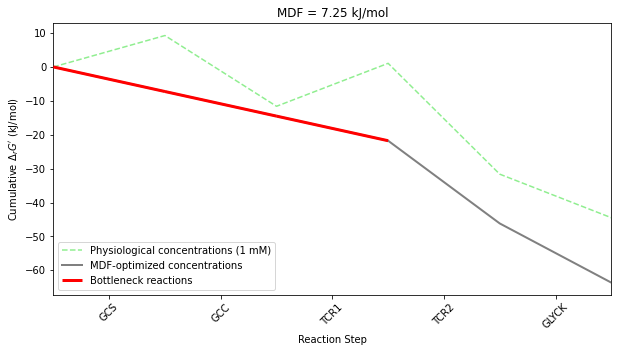

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mdf_result_TaCo.plot_driving_forces(ax)
fig.savefig('TaCo_MDF.eps')

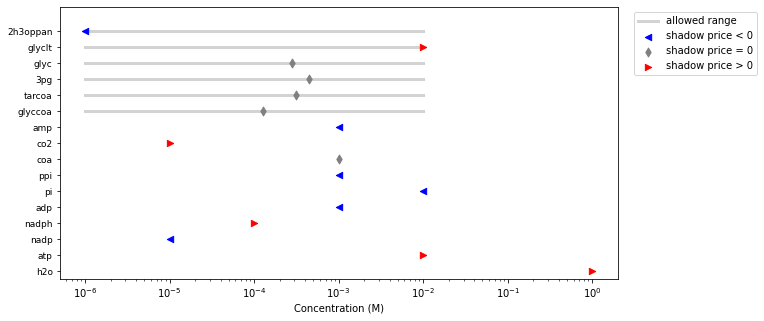

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mdf_result_TaCo.plot_concentrations(ax)

### MDF analysis of CBB

In [12]:
CBB = ThermodynamicModel.from_sbtab("CBB.tsv", comp_contrib=comp_contrib)

CBB.update_standard_dgs()
mdf_result_CBB = CBB.mdf_analysis()

In [13]:
mdf_result_CBB.reaction_df

,reaction_id,reaction_formula,flux,standard_dg_prime,physiological_dg_prime,optimized_dg_prime,shadow_price
0,RBPC,h2o + co2 + rb15bp -> 2 3pg,3.00 mM/s,-26.39 kJ/mol,-26.39 kJ/mol,-8.30 kJ/mol,0.00000
1,PGK,atp + 3pg -> adp + 13dpg,5.00 mM/s,19.32 kJ/mol,19.32 kJ/mol,-7.81 kJ/mol,0.21429
2,GAPDH,nadph + 13dpg <=> nadp + pi + g3p,5.00 mM/s,-4.47 kJ/mol,-21.59 kJ/mol,-7.81 kJ/mol,0.21429
3,TPI,g3p <=> dhap,2.00 mM/s,-5.58 kJ/mol,-5.58 kJ/mol,-7.81 kJ/mol,0.07143
4,FBA,g3p + dhap <=> fdp,1.00 mM/s,-22.39 kJ/mol,-5.28 kJ/mol,-9.49 kJ/mol,0.00000
5,FBP,h2o + fdp -> pi + f6p,1.00 mM/s,-12.77 kJ/mol,-29.88 kJ/mol,-8.16 kJ/mol,0.00000
6,TKT1,g3p + f6p <=> xu5p + e4p,1.00 mM/s,10.19 kJ/mol,10.19 kJ/mol,-7.81 kJ/mol,0.07143
7,FBP3,dhap + e4p <=> s17bp,1.00 mM/s,-20.84 kJ/mol,-3.72 kJ/mol,-7.81 kJ/mol,0.07143
8,SBP,h2o + s17bp -> pi + s7p,1.00 mM/s,-13.45 kJ/mol,-30.57 kJ/mol,-7.81 kJ/mol,0.07143
9,TKT2,g3p + s7p <=> r5p + xu5p,1.00 mM/s,3.88 kJ/mol,3.88 kJ/mol,-7.81 kJ/mol,0.07143


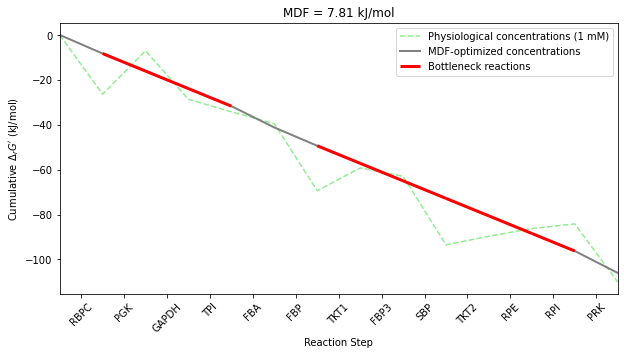

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mdf_result_CBB.plot_driving_forces(ax)
fig.savefig('CBB_MDF.eps')

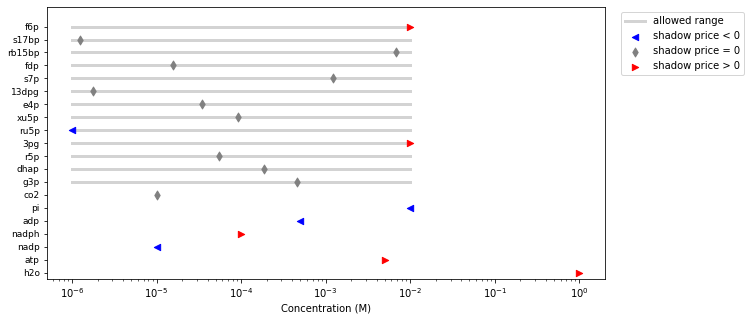

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mdf_result_CBB.plot_concentrations(ax)